In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB2

In [2]:
data_dir = '../COVID-19 Radiography Database'
IMG_SIZE = 260

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                                    validation_split=0.2,
                                                                    seed=123,
                                                                    subset="training",
                                                                    label_mode='int',
                                                                    batch_size=16,
                                                                    image_size=(IMG_SIZE,IMG_SIZE))
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                                  validation_split=0.2,
                                                                  shuffle=False,
                                                                  subset="validation",
                                                                  label_mode='int',
                                                                  batch_size=16,
                                                                  image_size=(IMG_SIZE,IMG_SIZE))

Found 2905 files belonging to 4 classes.
Using 2324 files for training.
Found 2905 files belonging to 4 classes.
Using 581 files for validation.


In [3]:
def plot_perfomance(history,range_epoch=25):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss= history.history['loss']
    val_loss= history.history['val_loss']

    epochs_range = range(range_epoch)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [4]:
img_augmentation = keras.models.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomRotation(factor=0.15),
        keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1,width_factor=0.1),
        keras.layers.experimental.preprocessing.RandomFlip(),
        keras.layers.experimental.preprocessing.RandomZoom(.5, .2),
    ],
    name="img_augmentation"
)

In [5]:
num_classes = len(train_dataset.class_names)
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
model = EfficientNetB2(include_top=False,input_tensor=x,weights='imagenet')
outputs = keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
outputs = keras.layers.BatchNormalization()(outputs)
outputs = keras.layers.Dropout(0.3)(outputs)
outputs = keras.layers.Dense(num_classes,activation="softmax",name="pred")(outputs)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model = tf.keras.Model(inputs,outputs)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=["accuracy"])

In [6]:
checkpoint_save = keras.callbacks.ModelCheckpoint('EfficientNet-B2 COVID-19.h5', 
                                           save_best_only=True,
                                           monitor='val_accuracy')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                              factor=0.5, 
                                              patience=1, 
                                              min_lr=0.00001)

In [7]:
epochs = 20
tf.keras.backend.clear_session()
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,
                    callbacks=[checkpoint_save,reduce_lr])

Epoch 1/20
146/146 [==============================] - 116s 797ms/step - loss: 0.9568 - accuracy: 0.6829 - val_loss: 0.7194 - val_accuracy: 0.7797
Epoch 2/20
146/146 [==============================] - 130s 891ms/step - loss: 0.5146 - accuracy: 0.8559 - val_loss: 0.5905 - val_accuracy: 0.8520
Epoch 3/20
146/146 [==============================] - 121s 829ms/step - loss: 0.3907 - accuracy: 0.8967 - val_loss: 0.4067 - val_accuracy: 0.8881
Epoch 4/20
146/146 [==============================] - 125s 853ms/step - loss: 0.3057 - accuracy: 0.9032 - val_loss: 0.3050 - val_accuracy: 0.9053
Epoch 5/20
146/146 [==============================] - 224s 2s/step - loss: 0.2661 - accuracy: 0.9281 - val_loss: 0.2988 - val_accuracy: 0.9243
Epoch 6/20
146/146 [==============================] - 121s 828ms/step - loss: 0.2822 - accuracy: 0.9230 - val_loss: 0.3448 - val_accuracy: 0.8967
Epoch 7/20
146/146 [==============================] - 121s 831ms/step - loss: 0.2345 - accuracy: 0.9204 - val_loss: 0.3173 - va

In [8]:
model = keras.models.load_model('EfficientNet-B2 COVID-19.h5')
val_loss, val_acc = model.evaluate(val_dataset)
print(f"validation loss : {val_loss} validation accuracy : {val_acc}")

37/37 [==============================] - 9s 245ms/step - loss: 0.2988 - accuracy: 0.0000e+00
validation loss : 0.29884588718414307 validation accuracy : 0.0


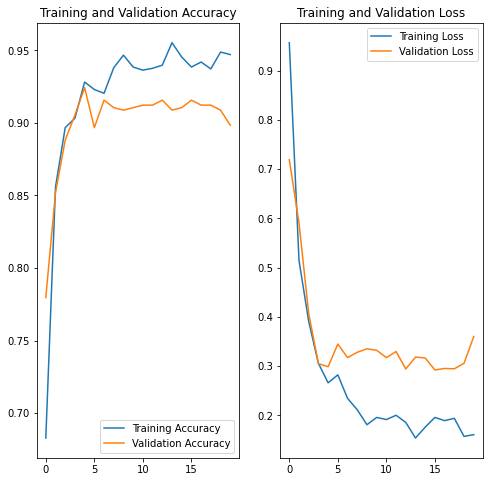

In [9]:
plot_perfomance(history,epochs)

In [10]:
# model.save('EfficientNet-B2 COVID-19.h5')